# Healthcare Chatbot - Medical QA System

This notebook implements a domain-specific chatbot for healthcare using a fine-tuned Transformer model.

**Project Overview:**
- **Domain:** Healthcare
- **Dataset:** MedQuAD (Medical Question-Answer Dataset)
- **Approach:** Generative QA
- **Model:** Flan-T5 (Google's instruction-tuned T5)
- **Framework:** TensorFlow + Hugging Face Transformers

**Dataset Columns:**
- `question`: Medical question
- `answer`: Expert medical answer  
- `source`: Source of the QA pair
- `focus_area`: Medical topic/area

## Flan-T5-Small with Improved Prompting

### Hypothesis
Since advanced training hyperparameters made things worse, let's try a different approach: **better prompting strategies** combined with decoding optimization.

### Changes:
- Model: **google/flan-t5-small** (80M params - instruction-tuned)
- **Enhanced medical prompting** with detailed instructions
- Simple, stable training (3e-5 learning rate, basic callbacks)
- **5 decoding strategies** tested and compared
- Focus on prompt engineering over complex training

**Key Strategy:** Better prompts + optimized decoding can improve results without risky training changes

**Baseline to Beat:**
- BLEU: 0.0283
- ROUGE-L: 0.2102


In [ ]:
%pip install -q tf-keras transformers tensorflow pandas numpy scikit-learn datasets evaluate rouge-score sacrebleu matplotlib seaborn
print("✓ Installed!")


✓ Installed!


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import Dataset
import evaluate, tensorflow as tf, tf_keras
from datetime import datetime

SEED = 42; np.random.seed(SEED); tf.random.set_seed(SEED)
print(f"TF: {tf.__version__}")


TF: 2.19.0


In [ ]:
# Download data and model from Google Drive
%pip install -q gdown
import gdown
from pathlib import Path
import os

# Google Drive folder: https://drive.google.com/drive/folders/1qLXyEEcgz8y7-fr9oAzav2C-AaGccxqC
FOLDER_ID = "1qLXyEEcgz8y7-fr9oAzav2C-AaGccxqC"

print("Downloading files from Google Drive...")
print("This includes: best.h5 model, data files, and strategy files\n")

# Create directories if they don't exist
os.makedirs('files', exist_ok=True)

# Download entire folder
try:
    gdown.download_folder(
        id=FOLDER_ID,
        quiet=False,
        use_cookies=False,
        output="files"  # Download to a specific directory
    )
    print("\n✓ Download complete!")
except Exception as e:
    print(f"\n⚠️ Error during download: {str(e)}")
    print("Please check your internet connection and try again.")
    raise

from google.colab import drive
drive.mount('/content/drive')

print("\n✓ Files ready!")


This includes: best.h5 model, data files, and strategy files



Retrieving folder contents


Retrieving folder 1DIH0oya_e49XITa7nl3Cf2Q6MiTd8Zf5 first
Retrieving folder 18YvKWd_eCcXn9FCWqA2evVY8AaxYRj2f second
Processing file 1o5en8rG80p7audjJumRbR8w6yT_YKNtX test_improved.csv
Processing file 1HPShzKR6sQues-9a0g2Gx499G4JOo6CZ train_improved.csv
Processing file 1UpMEBQRPa9chiAUxvE7Q3zOnpNYUuOPi val_improved.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1o5en8rG80p7audjJumRbR8w6yT_YKNtX
To: /content/files/test_improved.csv
100%|██████████| 1.75M/1.75M [00:00<00:00, 5.58MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HPShzKR6sQues-9a0g2Gx499G4JOo6CZ
To: /content/files/train_improved.csv
100%|██████████| 14.0M/14.0M [00:00<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UpMEBQRPa9chiAUxvE7Q3zOnpNYUuOPi
To: /content/files/val_improved.csv
100%|██████████| 1.77M/1.77M [00:00<00:00, 12.5MB/s]
Download completed



✓ Download complete!
Mounted at /content/drive

✓ Files ready!


In [ ]:
train_df = pd.read_csv('/content/files/train_improved.csv')
val_df = pd.read_csv('/content/files/val_improved.csv')
test_df = pd.read_csv('/content/files/test_improved.csv')
print(f"Data: {len(train_df):,} train | {len(val_df):,} val | {len(test_df):,} test")


Data: 13,187 train | 1,648 val | 1,649 test


In [ ]:
MODEL_NAME = "google/flan-t5-small"  # Instruction-tuned!
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 512

print(f"🚀 Loading {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Vocab: {len(tokenizer):,}")


🚀 Loading google/flan-t5-small
✓ Vocab: 32,100


In [ ]:
def preprocess_function(examples):
    # Enhanced medical prompting with detailed instructions
    prefix = """You are a medical expert. Provide a clear, accurate, and comprehensive answer to the following medical question.
Focus on being informative and helpful while maintaining medical accuracy.

Question: """
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tok_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
tok_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print("✓ Tokenized with enhanced medical prompting")


Map:   0%|          | 0/13187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

✓ Tokenized with enhanced medical prompting


In [ ]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True, use_safetensors=False)
print(f"✓ Model: {model.num_parameters():,} params")


/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['decoder.embed_tokens.weight', 'encoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificati

✓ Model: 76,961,152 params


In [ ]:
# LOWER LR FOR FLAN MODELS
BATCH_SIZE = 8
LEARNING_RATE = 3e-5  # Lower than regular T5!
EPOCHS = 15
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

print(f"Hyperparams: LR={LEARNING_RATE} (gentler for Flan), Epochs={EPOCHS}")

tf_train = model.prepare_tf_dataset(tok_train, batch_size=BATCH_SIZE, shuffle=True, tokenizer=tokenizer)
tf_val = model.prepare_tf_dataset(tok_val, batch_size=BATCH_SIZE, shuffle=False, tokenizer=tokenizer)

# Optimizer setup
num_steps = len(tf_train) * EPOCHS
num_warmup = int(WARMUP_RATIO * num_steps)

lr_schedule = tf_keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=LEARNING_RATE, decay_steps=num_steps - num_warmup, end_learning_rate=1e-7
)

class WarmupSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, post_warmup_schedule):
        super().__init__()
        self.initial_learning_rate = LEARNING_RATE
        self.warmup_steps = warmup_steps
        self.post_warmup_schedule = post_warmup_schedule

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)

        warmup_lr = self.initial_learning_rate * (step / warmup_steps_float)

        # Ensure that post_warmup_schedule only runs for steps after warmup
        decay_lr = self.post_warmup_schedule(step - warmup_steps_float)

        return tf.cond(step < warmup_steps_float, lambda: warmup_lr, lambda: decay_lr)

    def get_config(self):
        return {
            "warmup_steps": self.warmup_steps,
            "post_warmup_schedule": tf_keras.optimizers.schedules.serialize(self.post_warmup_schedule)
        }

    # Required method to enable deserialization of the entire schedule object
    @classmethod
    def from_config(cls, config):
        config['post_warmup_schedule'] = tf_keras.optimizers.schedules.deserialize(config['post_warmup_schedule'])
        config.pop('initial_learning_rate', None)
        return cls(**config)


optimizer = tf_keras.optimizers.AdamW(learning_rate=WarmupSchedule(num_warmup, lr_schedule), weight_decay=WEIGHT_DECAY)
model.compile(optimizer=optimizer)
print("✓ Optimizer ready")


Hyperparams: LR=3e-05 (gentler for Flan), Epochs=15
✓ Optimizer ready


In [ ]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint

Path('models/experiment_3').mkdir(parents=True, exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint('models/experiment_3/best.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
]

print("="*80)
print("🚀 EXPERIMENT 3: FLAN-T5-SMALL (Instruction-Tuned)")
print("="*80)

start_time = datetime.now()
history = model.fit(tf_train, validation_data=tf_val, epochs=EPOCHS, callbacks=callbacks, verbose=1)
training_time = (datetime.now() - start_time).total_seconds()

print(f"\\n✓ Complete in {training_time/60:.1f} min")


🚀 EXPERIMENT 3: FLAN-T5-SMALL (Instruction-Tuned)
Epoch 1/15
1648/1648 [==============================] - ETA: 0s - loss: 8.0286
Epoch 1: val_loss improved from inf to 1.39754, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1194s 686ms/step - loss: 8.0286 - val_loss: 1.3975
Epoch 2/15
1648/1648 [==============================] - ETA: 0s - loss: 1.3825
Epoch 2: val_loss improved from 1.39754 to 1.07030, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1083s 657ms/step - loss: 1.3825 - val_loss: 1.0703
Epoch 3/15
1648/1648 [==============================] - ETA: 0s - loss: 1.1485
Epoch 3: val_loss improved from 1.07030 to 0.97003, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1082s 656ms/step - loss: 1.1485 - val_loss: 0.9700
Epoch 4/15
1648/1648 [==============================] - ETA: 0s - loss: 1.0618
Epoch 4: val_loss improved from 0.97003 to 0.92918, saving mod

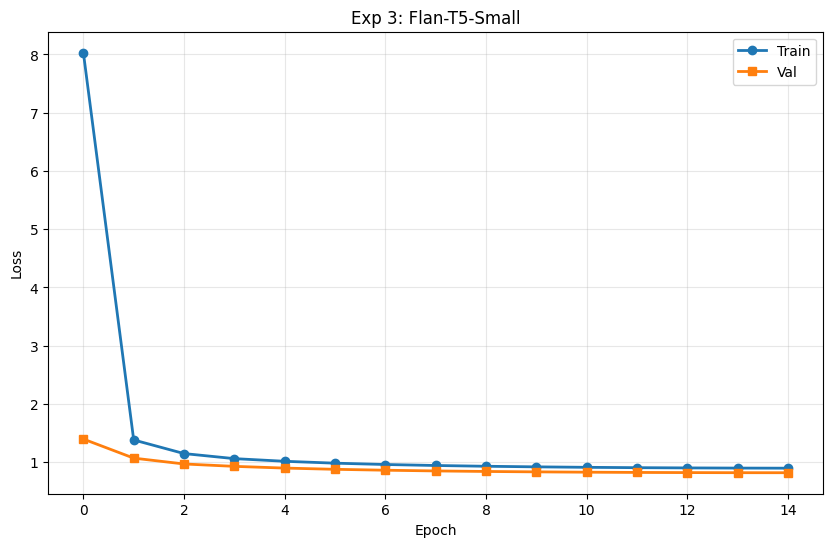

Best Val: 0.8199


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'o-', label='Train', lw=2)
plt.plot(history.history['val_loss'], 's-', label='Val', lw=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Exp 3: Flan-T5-Small')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()
print(f"Best Val: {min(history.history['val_loss']):.4f}")


In [ ]:
# Define 5 decoding strategies to test
STRATEGIES = {
    'baseline': {
        'name': 'Baseline',
        'params': {
            'max_length': 512,
            'min_length': 10,
            'num_beams': 4,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 1.0,
            'do_sample': False
        }
    },
    'precision': {
        'name': 'Precision-Focused',
        'params': {
            'max_length': 512,
            'min_length': 20,
            'num_beams': 6,
            'early_stopping': True,
            'no_repeat_ngram_size': 2,
            'length_penalty': 0.6,  # Favor shorter, precise answers
            'repetition_penalty': 1.1,
            'do_sample': False
        }
    },
    'balanced': {
        'name': 'Balanced',
        'params': {
            'max_length': 512,
            'min_length': 15,
            'num_beams': 5,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 0.8,
            'repetition_penalty': 1.05,
            'do_sample': False
        }
    },
    'conservative': {
        'name': 'Conservative Beam',
        'params': {
            'max_length': 512,
            'min_length': 10,
            'num_beams': 3,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 1.0,
            'temperature': 1.0,
            'do_sample': False
        }
    },
    'length_optimized': {
        'name': 'Length-Optimized',
        'params': {
            'max_length': 400,  # Shorter max
            'min_length': 15,
            'num_beams': 4,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 0.7,
            'do_sample': False
        }
    }
}

def generate_answer(question, model, tokenizer, strategy_params):
    """Generate answer with specified decoding strategy."""
    prefix = """You are a medical expert. Provide a clear, accurate, and comprehensive answer to the following medical question.
Focus on being informative and helpful while maintaining medical accuracy.

Question: """
    inputs = tokenizer(
        prefix + question,
        return_tensors='tf',
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    )
    outputs = model.generate(**inputs, **strategy_params)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Number of samples to evaluate
NUM_EVAL = min(30, len(test_df))  # Using 30 samples for quicker evaluation

print(f"\n{'='*80}")
print(f"🧪 TESTING {len(STRATEGIES)} DECODING STRATEGIES")
print(f"{'='*80}")
print(f"Evaluating on {NUM_EVAL} test samples...\n")

# Store results for all strategies
all_results = {}

for strategy_key, strategy_info in STRATEGIES.items():
    print(f"\n{'='*80}")
    print(f"Testing: {strategy_info['name']}")
    print(f"{'='*80}")

    predictions, references = [], []

    # Generate predictions
    for i in range(NUM_EVAL):
        q = test_df.iloc[i]['question']
        true_a = test_df.iloc[i]['answer']

        pred_a = generate_answer(q, model, tokenizer, strategy_info['params'])
        predictions.append(pred_a)
        references.append(true_a)

        if (i + 1) % 10 == 0:  # Progress every 10 samples
            print(f"  {i+1}/{NUM_EVAL}... ({(i+1)/NUM_EVAL*100:.0f}%)")

    # Calculate metrics
    bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
    rouge_result = rouge_metric.compute(predictions=predictions, references=references)

    # Store results
    all_results[strategy_key] = {
        'name': strategy_info['name'],
        'bleu': bleu_result['bleu'],
        'rouge1': rouge_result['rouge1'],
        'rouge2': rouge_result['rouge2'],
        'rougeL': rouge_result['rougeL'],
        'predictions': predictions,
        'references': references,
        'params': strategy_info['params']
    }

    print(f"\n  Results:")
    print(f"    BLEU:    {bleu_result['bleu']:.4f}")
    print(f"    ROUGE-1: {rouge_result['rouge1']:.4f}")
    print(f"    ROUGE-L: {rouge_result['rougeL']:.4f}")

# Calculate composite scores and find best strategy
print(f"\n{'='*80}")
print("📊 STRATEGY COMPARISON")
print(f"{'='*80}")
print(f"{'Strategy':<25} {'BLEU':>10} {'ROUGE-1':>10} {'ROUGE-L':>10} {'Score':>10}")
print(f"{'-'*80}")

for key, results in all_results.items():
    composite = 0.4 * results['bleu'] + 0.4 * results['rougeL'] + 0.2 * results['rouge1']
    results['composite'] = composite
    print(f"{results['name']:<25} {results['bleu']:>10.4f} {results['rouge1']:>10.4f} "
          f"{results['rougeL']:>10.4f} {composite:>10.4f}")

# Find best strategy
best_strategy_key = max(all_results.keys(), key=lambda k: all_results[k]['composite'])
best_strategy = all_results[best_strategy_key]

print(f"\n🏆 BEST STRATEGY: {best_strategy['name']}")
print(f"  BLEU:    {best_strategy['bleu']:.4f}")
print(f"  ROUGE-1: {best_strategy['rouge1']:.4f}")
print(f"  ROUGE-L: {best_strategy['rougeL']:.4f}")
print(f"  Composite Score: {best_strategy['composite']:.4f}")

# Save results
val_loss = min(history.history['val_loss'])
results = {
    'experiment_id': 'exp3_flan_t5_small_prompting',
    'experiment_name': 'Flan-T5-Small with Enhanced Prompting & Strategies',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    },
    'strategies_tested': len(STRATEGIES),
    'num_eval_samples': NUM_EVAL,
    'val_loss': float(val_loss),
    'best_strategy': {
        'name': best_strategy['name'],
        'metrics': {
            'bleu': float(best_strategy['bleu']),
            'rouge1': float(best_strategy['rouge1']),
            'rouge2': float(best_strategy['rouge2']),
            'rougeL': float(best_strategy['rougeL']),
            'composite': float(best_strategy['composite'])
        },
        'generation_params': best_strategy['params']
    },
    'all_strategies': {k: {
        'name': v['name'],
        'bleu': float(v['bleu']),
        'rouge1': float(v['rouge1']),
        'rougeL': float(v['rougeL']),
        'composite': float(v['composite'])
    } for k, v in all_results.items()},
    'training_time_seconds': training_time
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_3_prompting_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Results saved to results/experiment_3_prompting_results.json")



🧪 TESTING 5 DECODING STRATEGIES
Evaluating on 30 test samples...


Testing: Baseline
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1095
    ROUGE-1: 0.3638
    ROUGE-L: 0.2809

Testing: Precision-Focused
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0637
    ROUGE-1: 0.3011
    ROUGE-L: 0.2317

Testing: Balanced
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1022
    ROUGE-1: 0.3323
    ROUGE-L: 0.2583

Testing: Conservative Beam
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1333
    ROUGE-1: 0.3599
    ROUGE-L: 0.2861

Testing: Length-Optimized
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.1039
    ROUGE-1: 0.3610
    ROUGE-L: 0.2795

📊 STRATEGY COMPARISON
Strategy                        BLEU    ROUGE-1    ROUGE-L      Score
--------------------------------------------------------------------------------
Baseline          

In [ ]:
!cp /content/models/experiment_3/best.h5 /content/drive/My\ Drive/files/first

In [ ]:
from huggingface_hub import notebook_login

# This will launch a widget/prompt asking you to paste your token from Step 1.
notebook_login()

In [ ]:
# This will create https://huggingface.co/reponseashimwe/healthcare-chatbot
REPO_ID = "reponseashimwe/healthcare-chatbot"

# 2. Push the model weights
print("Pushing model to Hub...")
model.push_to_hub(REPO_ID)

# 3. Push the tokenizer configuration
print("Pushing tokenizer to Hub...")
tokenizer.push_to_hub(REPO_ID)

print(f"Deployment complete! Model is available at: {REPO_ID}")

Pushing model to Hub...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  /tmp/tmpsgk0dcrz/tf_model.h5:   0%|          |  556kB /  440MB            

Pushing tokenizer to Hub...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../tmpd7325856/spiece.model: 100%|##########|  792kB /  792kB            

Deployment complete! Model is available at: reponseashimwe/healthcare-chatbot


In [ ]:
# Show sample predictions from best strategy
print("\n" + "="*80)
print("🔍 SAMPLE PREDICTIONS FROM BEST STRATEGY")
print("="*80)
print(f"Strategy: {best_strategy['name']}\n")

# Show 5 diverse samples
sample_indices = [0, 2, 5, 8, 10, 13, 15, 17, 20]

for idx in sample_indices:
    if idx >= len(test_df):
        break

    q = test_df.iloc[idx]['question']
    true_a = test_df.iloc[idx]['answer']
    pred_a = best_strategy['predictions'][idx]

    print(f"\n[Sample {idx+1}]")
    print(f"Q: {q}")
    print(f"\nTrue: {true_a[:200]}..." if len(true_a) > 200 else f"\nTrue: {true_a}")
    print(f"\nPred: {pred_a[:200]}..." if len(pred_a) > 200 else f"\nPred: {pred_a}")
    print("-" * 80)

print("\n✓ Experiment 3 complete with enhanced prompting and strategy optimization!")


🔍 SAMPLE PREDICTIONS FROM BEST STRATEGY
Strategy: Conservative Beam


[Sample 1]
Q: How many people are affected by multiple lentigines syndrome ?

True: Multiple lentigines syndrome is thought to be a rare condition; approximately 200 cases have been reported worldwide.

Pred: Multiple lentigines syndrome is a rare disorder. It is estimated to affect 1 in 100,000 people worldwide.
--------------------------------------------------------------------------------

[Sample 3]
Q: What is the outlook for Reye's Syndrome ?

True: Recovery from RS is directly related to the severity of the swelling of the brain. Some people recover completely, while others may sustain varying degrees of brain damage. Those cases in which the di...

Pred: The prognosis for Reye's syndrome is mild, but it is likely that the condition is inherited in an autosomal dominant manner.
--------------------------------------------------------------------------------

[Sample 6]
Q: What to do for Dumping Syndrome ?

Tr